<a href="https://colab.research.google.com/github/SeanSong25/Awesome-CV/blob/master/480A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
import numpy as np
from torch.utils.data import Subset

def reduce_dataset(dataset, num_per_class):
    targets = dataset.targets.numpy()
    classes = np.unique(targets)
    indices = []

    for cls in classes:
        cls_indices = np.where(targets == cls)[0]
        selected_indices = np.random.choice(cls_indices, num_per_class, replace=False)
        indices.extend(selected_indices)

    return Subset(dataset, indices)

print(len(train_dataset))
print(len(test_dataset))

# Reduce the training set to 1/10 (~600 images per class)
reduced_train_dataset = reduce_dataset(train_dataset, 600)

# Create data loaders
train_loader = DataLoader(dataset=reduced_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

60000
10000


In [4]:
# Define the VGG11 model
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(4096, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [5]:
# Instantiate the model, loss function, and optimizer
model = VGG11()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG11(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(

In [6]:
# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 5

# Initialize lists to hold metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 10:.4f}")
            running_loss = 0.0

    # Calculate and record training accuracy and loss
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Save the trained model
torch.save(model.state_dict(), 'vgg11_mnist.pth')

# Plot the metrics
epochs = range(1, num_epochs + 1)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 10))

# plt.subplot(2, 2, 1)
# plt.plot(epochs, test_accuracies, 'b', label='Test Accuracy')
# plt.title('Test Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.legend()

# plt.subplot(2, 2, 2)
# plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
# plt.title('Training Accuracy vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy (%)')
# plt.legend()

# plt.subplot(2, 2, 3)
# plt.plot(epochs, test_losses, 'b', label='Test Loss')
# plt.title('Test Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(2, 2, 4)
# plt.plot(epochs, train_losses, 'r', label='Training Loss')
# plt.title('Training Loss vs. Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.show()

Epoch [1/5], Step [10/94], Loss: 3.1011
Epoch [1/5], Step [20/94], Loss: 2.2081
Epoch [1/5], Step [30/94], Loss: 1.9322
Epoch [1/5], Step [40/94], Loss: 1.8558
Epoch [1/5], Step [50/94], Loss: 1.7646
Epoch [1/5], Step [60/94], Loss: 1.6628
Epoch [1/5], Step [70/94], Loss: 1.6150
Epoch [1/5], Step [80/94], Loss: 1.4571
Epoch [1/5], Step [90/94], Loss: 1.4007
Epoch [1/5], Training Loss: 0.0632, Training Accuracy: 25.68%, Test Loss: 1.4152, Test Accuracy: 32.12%
Epoch [2/5], Step [10/94], Loss: 1.2935
Epoch [2/5], Step [20/94], Loss: 1.1937
Epoch [2/5], Step [30/94], Loss: 1.2065
Epoch [2/5], Step [40/94], Loss: 0.9772
Epoch [2/5], Step [50/94], Loss: 0.8212
Epoch [2/5], Step [60/94], Loss: 0.7254
Epoch [2/5], Step [70/94], Loss: 0.6545
Epoch [2/5], Step [80/94], Loss: 0.5795
Epoch [2/5], Step [90/94], Loss: 0.5445
Epoch [2/5], Training Loss: 0.0181, Training Accuracy: 63.62%, Test Loss: 0.2862, Test Accuracy: 91.07%
Epoch [3/5], Step [10/94], Loss: 0.3668
Epoch [3/5], Step [20/94], Loss:

In [8]:
# import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision

# Load the original MNIST test dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Define transformations for horizontal and horizontal + vertical flipping
horizontal_flip_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

vertical_flip_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomVerticalFlip(p=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets and loaders for flipped images
test_dataset_horizontal_flip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=horizontal_flip_transform)
test_loader_horizontal_flip = DataLoader(dataset=test_dataset_horizontal_flip, batch_size=64, shuffle=False)

test_dataset_vertical_flip = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=vertical_flip_transform)
test_loader_vertical_flip = DataLoader(dataset=test_dataset_vertical_flip, batch_size=64, shuffle=False)

# Function to evaluate the model
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Load the trained model
model = VGG11()
model.load_state_dict(torch.load('vgg11_mnist.pth'))
model.to(device)

# Evaluate the model on original, horizontally flipped, and horizontally then vertically flipped test sets
original_test_accuracy = evaluate_model(model, test_loader)
horizontal_flip_test_accuracy = evaluate_model(model, test_loader_horizontal_flip)
horizontal_vertical_flip_test_accuracy = evaluate_model(model, test_loader_vertical_flip)

# Print the results
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')
print(f'Horizontal Flip Test Accuracy: {horizontal_flip_test_accuracy:.2f}%')
print(f'Vertical Flip Test Accuracy: {horizontal_vertical_flip_test_accuracy:.2f}%')


Original Test Accuracy: 96.63%
Horizontal Flip Test Accuracy: 31.97%
Vertical Flip Test Accuracy: 34.81%


Original Test Accuracy: 96.76%
Test Accuracy with Gaussian Noise (std=0.1): 96.87%
Test Accuracy with Gaussian Noise (std=0.316): 88.85%
Test Accuracy with Gaussian Noise (std=1.0): 26.68%


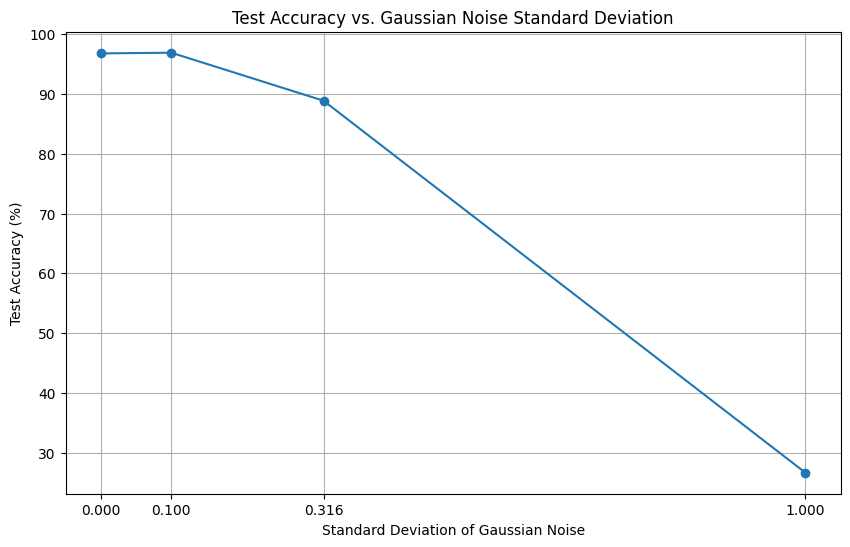

In [21]:
import matplotlib.pyplot as plt
# Define transformations for adding Gaussian noise
def add_gaussian_noise(x, std_dev):
    return x + std_dev * torch.randn_like(x)

# Define the noise levels (standard deviations)
noise_levels = [0.1, 0.316, 1.0]  # Corresponding to variances 0.01, 0.1, 1

# Create datasets and loaders for noisy images
test_loaders_noise = []
for std_dev in noise_levels:
    noisy_transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
        transforms.Lambda(lambda x: add_gaussian_noise(x, std_dev))
    ])
    noisy_test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=noisy_transform)
    noisy_test_loader = DataLoader(dataset=noisy_test_dataset, batch_size=64, shuffle=False)
    test_loaders_noise.append((std_dev, noisy_test_loader))

# Evaluate the model on original test set and noisy test sets
original_test_accuracy = evaluate_model(model, test_loader)
print(f'Original Test Accuracy: {original_test_accuracy:.2f}%')

noise_accuracies = []
for std_dev, noisy_test_loader in test_loaders_noise:
    noise_test_accuracy = evaluate_model(model, noisy_test_loader)
    noise_accuracies.append((std_dev, noise_test_accuracy))
    print(f'Test Accuracy with Gaussian Noise (std={std_dev}): {noise_test_accuracy:.2f}%')
# Plot the results
std_devs, accuracies = zip(*noise_accuracies)
plt.figure(figsize=(10, 6))
plt.plot([0] + list(std_devs), [original_test_accuracy] + list(accuracies), marker='o')
plt.title('Test Accuracy vs. Gaussian Noise Standard Deviation')
plt.xlabel('Standard Deviation of Gaussian Noise')
plt.ylabel('Test Accuracy (%)')
plt.xticks([0] + list(std_devs))
plt.grid(True)
plt.show()